In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv("ratings.csv",sep='\t',encoding='latin-1',usecols=['user_id','movie_id','rating'])
users = pd.read_csv("users.csv",sep='\t',encoding='latin-1',usecols=['user_id','gender','zipcode','age_desc','occ_desc'])
movies = pd.read_csv('movies.csv',sep='\t',encoding='latin-1',usecols=['movie_id','title','genres'])

In [3]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [4]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


In [5]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
%matplotlib inline 
import wordcloud 
from wordcloud import WordCloud , STOPWORDS

In [7]:
movies['title']= movies['title'].fillna("")

In [8]:
title_corpus = ''.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black',height=2000, width = 4000).generate(title_corpus)

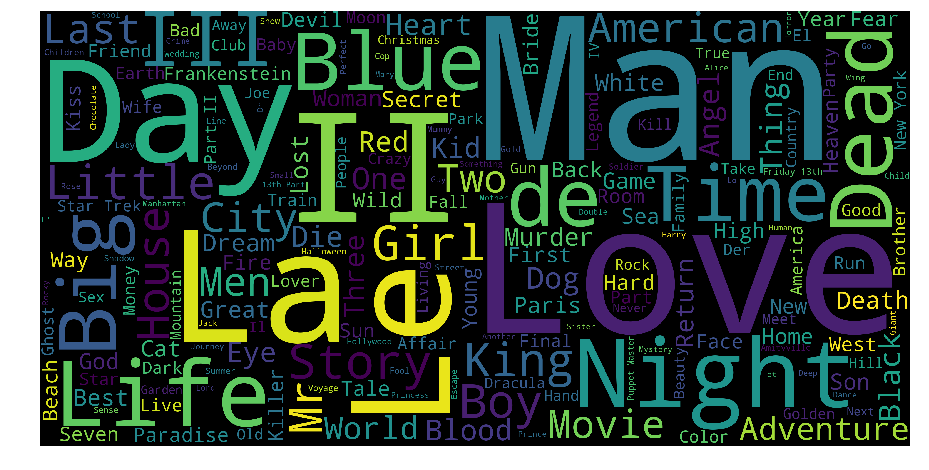

In [9]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

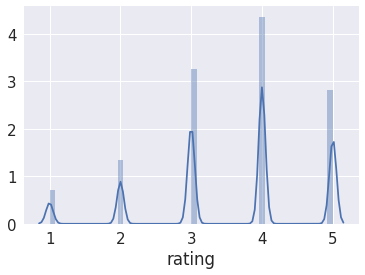

In [10]:
import seaborn as sns 
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline 

sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [11]:
dataset = pd.merge(pd.merge(movies,ratings),users)



In [12]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels= genre_labels.union(set(s))
    
def count_word(dataset , ref_col , census):
    keyword_count = dict()
    for s in census:
        keyword_count[s]=0
    for census_keywords in dataset[ref_col].str.split('|'):
        if type(census_keywords)== float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1
                
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count


keyword_occurences, dum = count_word(movies , 'genres', genre_labels)
keyword_occurences[:5]
            
    

[[u'Drama', 1603],
 [u'Comedy', 1200],
 [u'Action', 503],
 [u'Thriller', 492],
 [u'Romance', 471]]

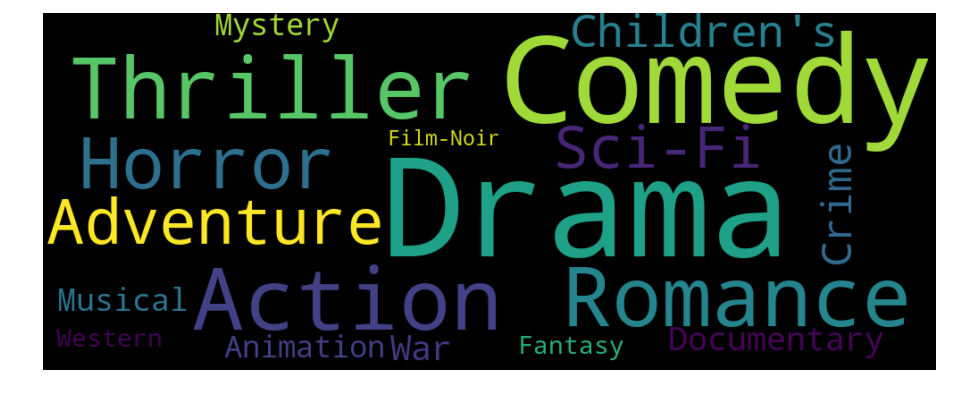

In [13]:
genres = dict()
trunc_occurnces = keyword_occurences[0:18]
for s in trunc_occurnces:
    genres[s[0]] = s[1]
    
genre_worldcloud = WordCloud(width=1000, height=400 , background_color='black')
genre_worldcloud.generate_from_frequencies(genres)

f, ax = plt.subplots(figsize=(16,8))
plt.imshow(genre_worldcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Content-Based Recommendation System

In [14]:
movies['genres'] = movies['genres'].str.split('|')

movies['genres'] = movies['genres'].fillna("").astype('str')

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1,2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(3883, 127)

In [16]:
from sklearn.metrics.pairwise import linear_kernel 
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
cosine_sim[:4,:4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

In [17]:
titles = movies['title']
indices = pd.Series(movies.index, index = movies['title'])

def genre_recommendation(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores , key = lambda x: x[1] , reverse= True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [18]:
genre_recommendation('Beautiful Girls (1996)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

# Collaborative Filtering Recommendation Model

In [19]:
ratings['user_id']= ratings['user_id'].fillna(0)
ratings['movie_id']= ratings['movie_id'].fillna(0)

ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())

In [20]:
small_data = ratings.sample(frac=0.02)

In [21]:
from sklearn import cross_validation as cv
train_data , test_data = cv.train_test_split(small_data , test_size=0.2)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
train_data_matrix = train_data.as_matrix(columns = ['user_id','movie_id','rating'])
test_data_matrix = test_data.as_matrix(columns= ['user_id','movie_id','rating'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [23]:
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)]=0 

In [24]:
item_correlation = 1- pairwise_distances(train_data_matrix.T , metric ='correlation')
item_correlation[np.isnan(item_correlation)]=0 

In [25]:
def predict(ratings, similarity , type='user'):
    if type=='user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:,np.newaxis])
        pred = mean_user_rating[:,np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type=='item':
        pred = ratings.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt 

def rmse(pred,actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred,actual))

In [27]:
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

In [28]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 1438.08693943
Item-based CF RMSE: 1668.88555292


In [29]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 698.776672438
Item-based CF RMSE: 130.447001591
